In [1]:
import argparse
import glob
import json
import logging
import os
from datetime import datetime
from typing import Optional

import ants
import numpy as np
import template_io as tio
import tifffile

from template_io import read_json_as_dict
from template_io import create_folder
from template_io import prepare_config_sample, download_file

from aind_ccf_reg.configs import PathLike
from aind_ccf_reg.preprocess import perc_normalization, Masking
from aind_ccf_reg.plots import plot_reg, plot_antsimgs, plot_reg_before_after
%matplotlib inline

# mask = Masking(ants_img)

In [2]:
from typing import List, Tuple

import numpy as np

# alpha scope
CCF_DIRECTIONS = {
    0: "Posterior_to_anterior",
    1: "Inferior_to_superior",
    2: "Left_to_right",
}



 
# CCF_DIRECTIONS = {
#     0: "Left_to_right",
#     1: "Inferior_to_superior",
#     2: "Posterior_to_anterior",
# }

SMARTSPIM_TEMPLATE_DIRECTIONS = {
    0: "Right_to_left",
    1: "Anterior_to_posterior",
    2: "Superior_to_inferior",
}


def get_adjustments(
    axes: dict, orientation: dict
) -> Tuple[List[tuple], List[int]]:
    """
    Computes the necessary swaps and flips to adjust the orientation of axes.

    This function compares the given axes with a reference orientation and determines
    the swaps and flips required to match the target orientation. It removes any
    redundant swaps where both elements in the tuple are the same, and ensures that
    inverse swaps are handled.

    Parameters
    ----------
    axes : dict
        A dictionary containing axis information from the acquisition.json file,
        where each entry includes the 'dimension' and 'direction' of the axis.
        Example format:
        ```
        {
            "axes": [
                {
                    "name": "X",
                    "dimension": 2,
                    "direction": "Anterior_to_posterior",
                    "unit": "micrometer"
                }
            ]
        }
        ```
    orientation : dict
        A dictionary specifying the reference orientation for each axis dimension.

    Returns
    -------
    swaps : list of tuple
        A list of tuples where each tuple contains two dimensions to be swapped.
    flips : list of int
        A list of integers where each integer represents an axis that needs to be flipped.
    """
    flips = []
    swaps = []
    for i in range(len(axes)):
        ax = axes[i]
        dim = ax["dimension"]
        direction = ax["direction"].lower()

        if orientation[dim].lower() == direction:
            # No change needed
            continue

        for idx, d in orientation.items():
            # Check if only a swap is needed
            if d.lower() == direction:
                swaps.append((dim, idx))
            # Check if flip is needed
            elif d.lower() == "_".join(direction.split("_")[::-1]):
                swaps.append((dim, idx))
                flips.append(idx)

    return swaps, flips


def adjust_array(arr: np.ndarray, swaps: list, flips: list) -> np.ndarray:
    """
    Adjusts a NumPy array by performing axis swaps and flips.

    This function reorders the axes of a NumPy array based on the specified
    swaps, and then flips the array along the specified axes.

    Parameters
    ----------
    arr : np.ndarray
        The input NumPy array to be adjusted.
    swaps : list of tuple
        A list of tuples representing the axes to be swapped. Each tuple contains
        two dimensions to be swapped.
    flips : list of int
        A list of integers representing the axes that should be flipped.

    Returns
    -------
    np.ndarray
        The adjusted NumPy array after the swaps and flips are applied.
    """
    if swaps:
        in_axis, out_axis = zip(*swaps)
        arr = np.moveaxis(arr, in_axis, out_axis)
    if flips:
        arr = np.flip(arr, axis=flips)
    return arr

In [3]:
# outprefix = "/results/"
# ccf_c = ants.image_read("/data/ccf_templates/average_template_25microns.tif")
# ccf_c
# ccf_c = perc_normalization(ccf_c)

# plot_antsimgs(ccf_c, 
#               f"{outprefix}/ccf_c",
#               title=f"ccf_c", 
#               vmin=0, vmax=1.5)


In [4]:
# ants_exaspim = ants.image_read("/data/exaspim_template_7sujects_nomask_25um_round6.nii.gz") # 25um
# ccf = ants.image_read('../data/allen_mouse_ccf/average_template/average_template_25.nii.gz')

# ccf = perc_normalization(ccf)
# print(f"Loaded ccf: {ccf}")
# plot_antsimgs(ccf, 
#               f"{outprefix}/ccf_template",
#               title=f"ccf_template", 
#               vmin=0, vmax=1.5)


# # ants.image_write(ccf, f"{outprefix}load_ccf.nii.gz")
# print(f"Loaded ants_exaspim: {ants_exaspim}")

# plot_antsimgs(ants_exaspim, 
#               f"{outprefix}/exaspim_template",
#               title=f"exaspim_template", 
#               vmin=0, vmax=1.5)

    

In [5]:
tp = [
    {'dimension': 2, 'direction': 'Anterior_to_posterior', 'name': 'X', 'unit': 'micrometer'}, 
    {'dimension': 1, 'direction': 'Right_to_left', 'name': 'Y', 'unit': 'micrometer'}, 
    {'dimension': 0, 'direction': 'Inferior_to_superior', 'name': 'Z', 'unit': 'micrometer'}
]

for axis in tp:
    if axis['direction'] == 'Inferior_to_superior':
        axis['direction'] = 'Superior_to_inferior'

print(tp)

[{'dimension': 2, 'direction': 'Anterior_to_posterior', 'name': 'X', 'unit': 'micrometer'}, {'dimension': 1, 'direction': 'Right_to_left', 'name': 'Y', 'unit': 'micrometer'}, {'dimension': 0, 'direction': 'Superior_to_inferior', 'name': 'Z', 'unit': 'micrometer'}]


5
['/data/test_samples/715346_25um.json', '/data/test_samples/717445_25um.json', '/data/test_samples/719652_25um.json', '/data/test_samples/751473_25um.json', '/data/test_samples/754610_25um.json']
dataset_id: 715346
alignment_channel_path: s3://aind-open-data/exaSPIM_715346_2024-12-04_11-46-31_flatfield-correction_2025-05-28_20-37-56_fusion_2025-05-28_20-54-10/fused.zarr
(226, 225, 486)
[{'dimension': 2, 'direction': 'Anterior_to_posterior', 'name': 'X', 'unit': 'micrometer'}, {'dimension': 1, 'direction': 'Inferior_to_superior', 'name': 'Y', 'unit': 'micrometer'}, {'dimension': 0, 'direction': 'Left_to_right', 'name': 'Z', 'unit': 'micrometer'}]

***swaps [(2, 0), (0, 2)], flips [0]
dataset_id: 717445
alignment_channel_path: s3://aind-open-data/exaSPIM_717445_2024-05-28_13-16-10_flatfield-correction_2025-05-28_20-37-56_fusion_2025-05-28_20-54-09/fused.zarr
(228, 225, 487)
[{'dimension': 2, 'direction': 'Anterior_to_posterior', 'name': 'X', 'unit': 'micrometer'}, {'dimension': 1, 'dir

PathNotFoundError: nothing found at path ''

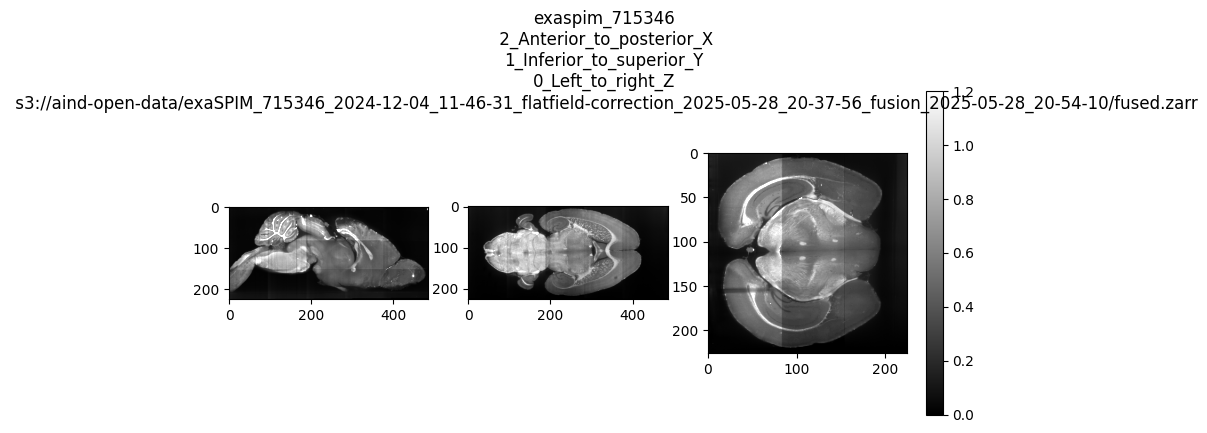

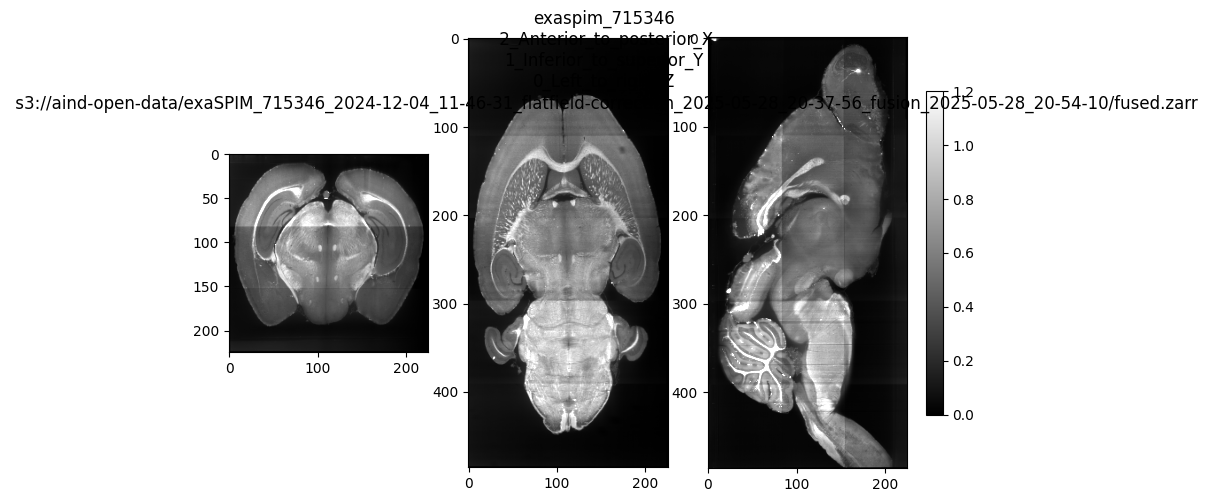

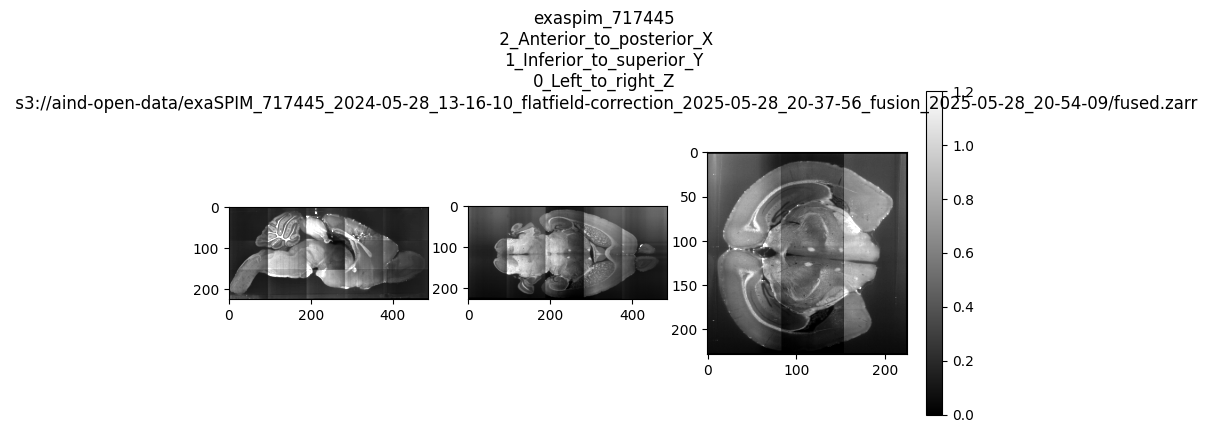

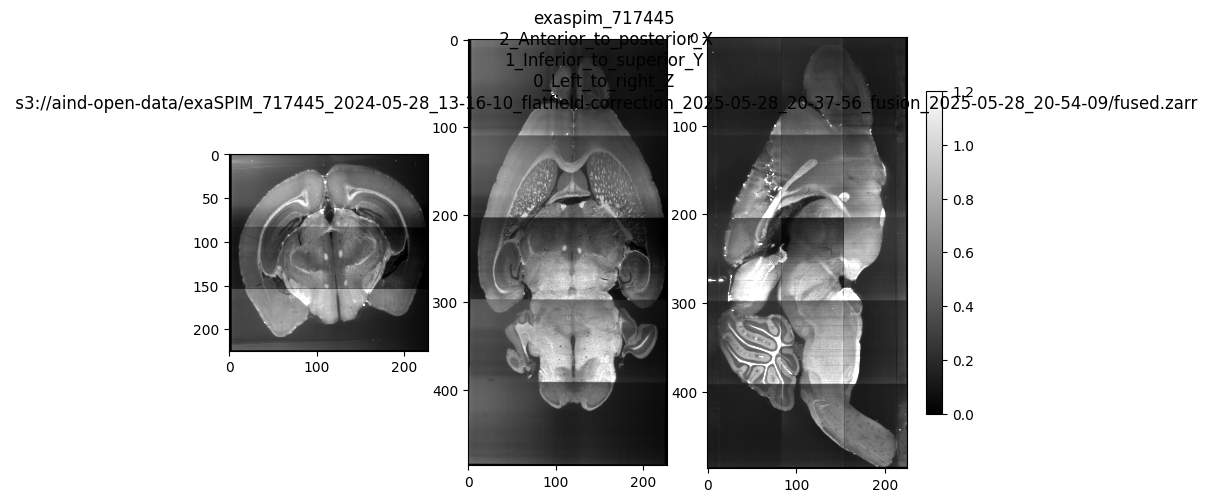

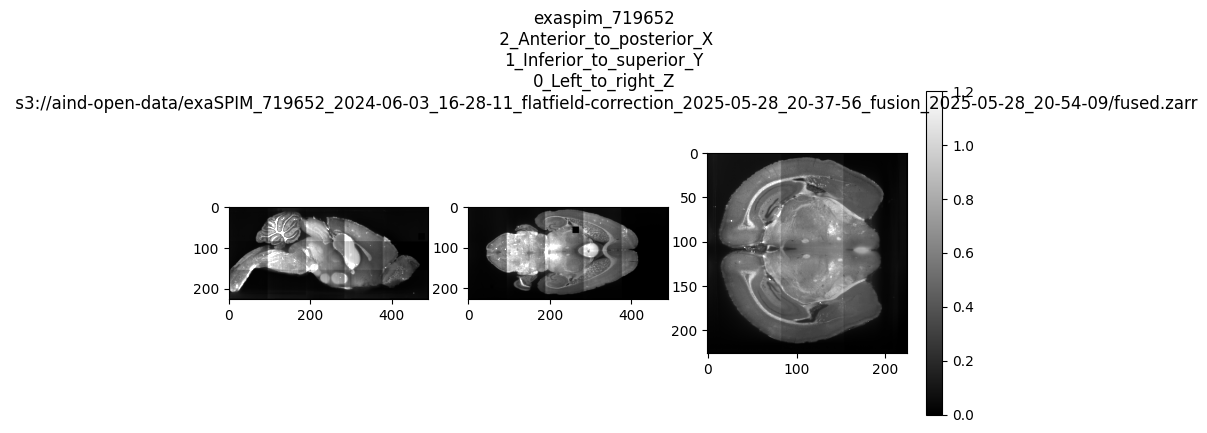

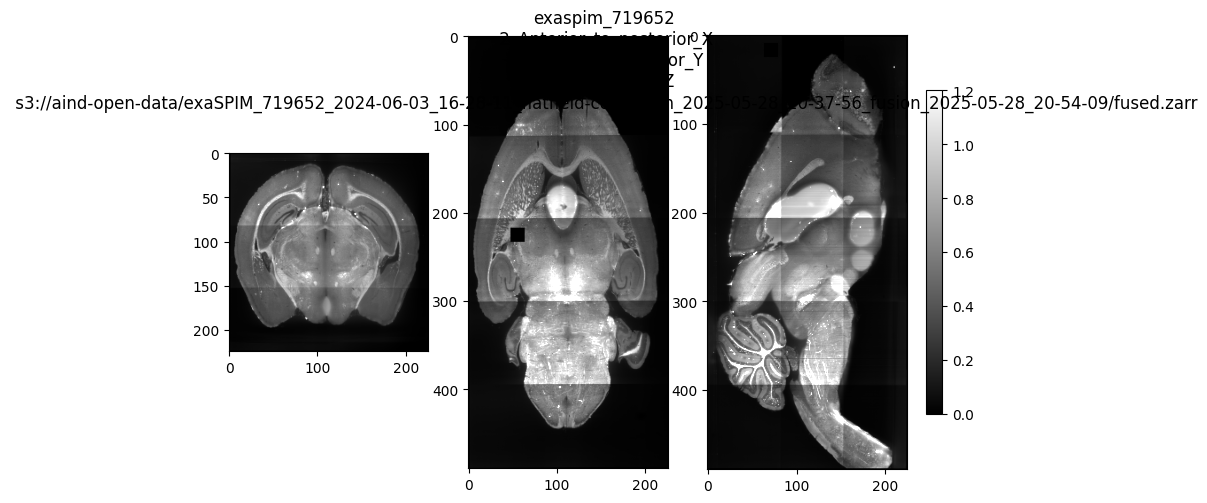

In [11]:
import zarr

# DATA_FOLDER = "/data/check_orientation_jsons/"
DATA_FOLDER = "/data/check_beta_orientation/jsons"
# DATA_FOLDER = "/data/test_soma_detection/"

json_files = sorted(glob.glob(f"{DATA_FOLDER}/*.json"))


json_files = [
        # "/data/test_samples/653158_25um.json",
        "/data/test_samples/719652_25um.json",
        "/data/test_samples/717445_25um.json",
        "/data/test_samples/715346_25um.json",
        "/data/test_samples/754610_25um.json",
        "/data/test_samples/751473_25um.json",
    
        #### beta scope
#         "/data/test_samples/721828_25um.json",
#         "/data/test_samples/754613_25um-test.json",
#         "/data/check_beta_orientation/jsons/754613_25um-test.json",
#         "/data/check_beta_orientation/jsons/759925_25um.json",
#         "/data/check_beta_orientation/jsons/720164_25um.json",
#         "/data/check_beta_orientation/jsons/763259_25um.json",
#         "/data/check_beta_orientation/jsons/754613_25um-test_signal.json",
#         "/data/test_samples/744783_25um-test.json",
#         "/data/test_samples/744783_25um-test.json",
    
    ]
json_files = sorted(json_files)
print(len(json_files))
print(json_files)
outprefix = "/results/" 


# # beta scope
# CCF_DIRECTIONS = {
#     0: "Anterior_to_posterior",
#     1: "Superior_to_inferior",
#     2: "Left_to_right",
# }

# alpha scope
CCF_DIRECTIONS = {
    0: "Posterior_to_anterior",
    1: "Inferior_to_superior",
    2: "Left_to_right",
}

# CCF_DIRECTIONS = {
#     0: "Posterior_to_anterior",
#     1: "Inferior_to_superior",
#     2: "Left_to_right",
# }

# 652440
# 754615
# 751473
# 667997
# 686951
# 718168
# 754613
# 754611
# 721332
# 744783
# 754612
# 730223
# 751474



for filepath in json_files[:]:
    #----------------------------------#
    # download acquisition_path
    #----------------------------------#
    
    dataset_config = read_json_as_dict(filepath=filepath)
    # print(dataset_config)
    dataset_id = dataset_config.get("label")
    print(f"dataset_id: {dataset_id}")
    
    acquisition_path = dataset_config.get("metadata_path")
    # print(acquisition_path)
    acquisition_output = f"/results/acquisition_{dataset_id}.json"

    try:
        download_file(acquisition_path, acquisition_output)
    except FileNotFoundError:
        #download_file(f"{dataset_name}/exaSPIM_acquisition.json", acquisition_output)
        print("WRONG !!!"*10)
        break
        # pass

    #----------------------------------# 
    # Getting config info
    #----------------------------------#

    alignment_channel_path = dataset_config.get("alignment_channel_path")
    print(f"alignment_channel_path: {alignment_channel_path}")
    resolution = dataset_config.get("resolution")
    level = dataset_config.get("level")
    level = level+1
    # level = 6
    
    if not os.path.exists(acquisition_output):
        print(f"{acquisition_output} not exist")
        continue
    with open(acquisition_output, "r") as f:
        metadata = json.load(f)
    
    #----------------------------------#
    # load zarr
    #----------------------------------#
    
    image_path = str(alignment_channel_path)
    image = zarr.open(f"{image_path}/{level}", mode="r")
    # print(image.shape)
    image = np.squeeze(np.squeeze(np.array(image), axis=0), axis=0)
    print(image.shape)
    
    print(metadata['axes'])
    tp = [{'dimension': 2, 'direction': 'Posterior_to_anterior', 'name': 'X', 'unit': 'micrometer'}, 
          {'dimension': 1, 'direction': 'Right_to_left', 'name': 'Y', 'unit': 'micrometer'}, 
          {'dimension': 0, 'direction': 'Superior_to_inferior', 'name': 'Z', 'unit': 'micrometer'}]
    
          
    tp = metadata['axes']

    # for axis in tp:
    #     if axis['direction'] == 'Inferior_to_superior':
    #         axis['direction'] = 'Superior_to_inferior'
    #     if axis['direction'] == 'Superior_to_inferior':
    #         axis['direction'] = 'Inferior_to_superior'
    #     # if axis['direction'] == 'Right_to_left':
    #     #     axis['direction'] = 'Left_to_right'
    #     # if axis['direction'] == 'Left_to_right':
    #     #     axis['direction'] = 'Right_to_left'
    #     if axis['direction'] == 'Anterior_to_posterior':
    #         axis['direction'] = 'Posterior_to_anterior'
    #     if axis['direction'] == 'Posterior_to_anterior':
    #         axis['direction'] = 'Anterior_to_posterior'
    # print(tp)

    #----------
    
    ants_img = ants.from_numpy(image.astype(np.float32))
    ants_img = perc_normalization(ants_img)

    
    formatted_data = [f"{item['dimension']}_{item['direction']}_{item['name']}" for item in tp]
    formatted_data = "\n".join(formatted_data)
    formatted_data
    plot_antsimgs(ants_img, 
      f"{outprefix}/exaspim_{dataset_id}_before_orientation",
      title=f"exaspim_{dataset_id}\n {formatted_data}\n {alignment_channel_path}", 
      # title=alignment_channel_path, 
      vmin=0, vmax=1.2)

        
        
    
    # swaps, flips = get_adjustments(metadata['axes'], CCF_DIRECTIONS)
    swaps, flips = get_adjustments(tp, CCF_DIRECTIONS)
    print(f"\n***swaps {swaps}, flips {flips}")
    image = adjust_array(image, swaps, flips)
    #-----------     

    ants_img = ants.from_numpy(image.astype(np.float32))
    ants_img = perc_normalization(ants_img)

    plot_antsimgs(ants_img, 
          f"{outprefix}/exaspim_{dataset_id}",
          title=f"exaspim_{dataset_id}\n {formatted_data}\n {alignment_channel_path}", 
          # title=alignment_channel_path, 
          vmin=0, vmax=1.2)


## apply orientation

1
['/data/test_samples/721828_25um.json']
dataset_id: 721828
(1, 1, 150, 298, 491)
(150, 298, 491)
swaps [(2, 0), (1, 2), (0, 1)], flips [0, 2]


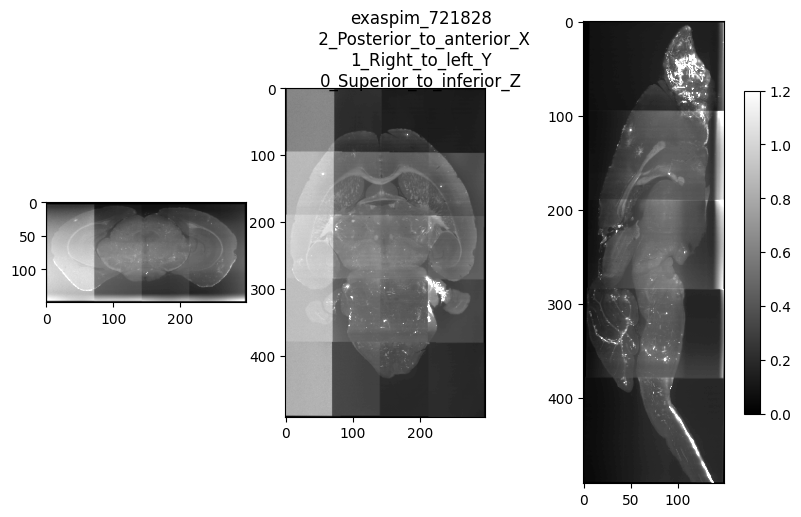

In [7]:


import zarr

# DATA_FOLDER = "/data/check_orientation_jsons/"
DATA_FOLDER = "/data/check_beta_orientation/"
json_files = sorted(glob.glob(f"{DATA_FOLDER}/*.json"))


json_files = [
        # "/data/test_samples/719652_25um.json",
        # "/data/test_samples/717445_25um.json",
        # "/data/test_samples/715346_25um.json",
        # "/data/test_samples/754610_25um.json",
        # "/data/test_samples/751473_25um.json",
        "/data/test_samples/721828_25um.json",
    # "/data/test_samples/648434_10um.json"
    ]
json_files = sorted(json_files)
print(len(json_files))
print(json_files)
outprefix = "/results/" 
for filepath in json_files[:]:
    #----------------------------------#
    # download acquisition_path
    #----------------------------------#
    
    dataset_config = read_json_as_dict(filepath=filepath)
    # print(dataset_config)
    dataset_id = dataset_config.get("label")
    print(f"dataset_id: {dataset_id}")
    
    acquisition_path = dataset_config.get("metadata_path")
    # print(acquisition_path)
    acquisition_output = f"/results/acquisition_{dataset_id}.json"

    try:
        download_file(acquisition_path, acquisition_output)
    except FileNotFoundError:
        #download_file(f"{dataset_name}/exaSPIM_acquisition.json", acquisition_output)
        pass

    #----------------------------------# 
    # Getting config info
    #----------------------------------#

    alignment_channel_path = dataset_config.get("alignment_channel_path")
    resolution = dataset_config.get("resolution")
    level = dataset_config.get("level")
    level = level+1
    
    if not os.path.exists(acquisition_output):
        print(f"{acquisition_output} not exist")
        continue
    with open(acquisition_output, "r") as f:
        metadata = json.load(f)
    
    #----------------------------------#
    # load zarr
    #----------------------------------#
    
    image_path = str(alignment_channel_path)
    image = zarr.open(f"{image_path}/{level}", mode="r")
    print(image.shape)
    zarr_image = np.squeeze(np.squeeze(np.array(image), axis=0), axis=0)
    print(zarr_image.shape)
    
    #----------
    swaps, flips = get_adjustments(metadata['axes'], CCF_DIRECTIONS)
    # swaps = [(2, 0), (1, 2), (0, 1)] # For 721828
    # flips = [0, 2]
    
    print(f"swaps {swaps}, flips {flips}")
    image = adjust_array(zarr_image, swaps, flips)
    #-----------     
        
    ants_img = ants.from_numpy(image.astype(np.float32))
    ants_img = perc_normalization(ants_img)
    

#     directions = ['RIP',
#                   'LIP',  'RSP',  'LSP',  'RIA',  'LIA',
#             'RSA',  'LSA',  'IRP',  'ILP',  'SRP',  'SLP',  'IRA',  'ILA',  'SRA',
#             'SLA',  'RPI',  'LPI',  'RAI',  'LAI',  'RPS',  'LPS',  'RAS',  'LAS',
#             'PRI',  'PLI',  'ARI',  'ALI',  'PRS',  'PLS',  'ARS',  'ALS',  'IPR',
#             'SPR',  'IAR',  'SAR',  'IPL',  'SPL',  'IAL',  'SAL',  'PIR',  'PSR',
#             'AIR',  'ASR',  'PIL',  'PSL',  'AIL',  'ASL'
#                  ]
#     for dire in directions:
#         ants_img1 = ants_img.reorient_image2(orientation=dire)
#         figpath = f"{outprefix}{dataset_id}_loaded_zarr_img_{dire}"
#         plot_antsimgs(ants_img1, figpath, title=f"{dataset_id}_loaded_zarr_img_{dire}", vmin=0, vmax=1.5)
    
    
    data = metadata['axes']
    
    formatted_data = [f"{item['dimension']}_{item['direction']}_{item['name']}" for item in data]
    formatted_data = "\n".join(formatted_data)
    formatted_data
    plot_antsimgs(ants_img, 
          f"{outprefix}/exaspim_{dataset_id}",
          title=f"exaspim_{dataset_id}\n {formatted_data}", 
          vmin=0, vmax=1.2)

    

In [14]:


import zarr

# DATA_FOLDER = "/data/check_orientation_jsons/"
DATA_FOLDER = "/data/check_beta_orientation/"
json_files = sorted(glob.glob(f"{DATA_FOLDER}/*.json"))


json_files = [
        # "/data/test_samples/719652_25um.json",
        # "/data/test_samples/717445_25um.json",
        # "/data/test_samples/715346_25um.json",
        # "/data/test_samples/754610_25um.json",
        # "/data/test_samples/751473_25um.json",
        # "/data/test_samples/721828_25um.json",
    "/data/test_samples/648434_10um.json"
    ]
json_files = sorted(json_files)
print(len(json_files))
print(json_files)
outprefix = "/results/" 
for filepath in json_files[:]:
    #----------------------------------#
    # download acquisition_path
    #----------------------------------#
    
    dataset_config = read_json_as_dict(filepath=filepath)
    dataset_id = dataset_config.get("label")
    print(f"dataset_id: {dataset_id}")
    
    acquisition_path = dataset_config.get("metadata_path")
    # print(acquisition_path)
    acquisition_output = f"/results/acquisition_{dataset_id}.json"

    try:
        download_file(acquisition_path, acquisition_output)
    except FileNotFoundError:
        #download_file(f"{dataset_name}/exaSPIM_acquisition.json", acquisition_output)
        pass

    #----------------------------------# 
    # Getting config info
    #----------------------------------#

    alignment_channel_path = dataset_config.get("alignment_channel_path")
    resolution = dataset_config.get("resolution")
    level = dataset_config.get("level")
    level = level+1
    
    if not os.path.exists(acquisition_output):
        print(f"{acquisition_output} not exist")
        continue
    with open(acquisition_output, "r") as f:
        metadata = json.load(f)
    
    #----------------------------------#
    # load zarr
    #----------------------------------#
    
    image_path = str(alignment_channel_path)
    image = zarr.open(f"{image_path}/{level}", mode="r")
    print(image.shape)
    image = np.squeeze(np.squeeze(np.array(image), axis=0), axis=0)
    print(image.shape)
    
    #----------
    swaps, flips = get_adjustments(metadata['axes'], CCF_DIRECTIONS)
    print(f"swaps {swaps}, flips {flips}")
    image = adjust_array(image, swaps, flips)
    #-----------     
        
    ants_img = ants.from_numpy(image.astype(np.float32))
    ants_img = perc_normalization(ants_img)
    

    directions = ['RIP','LIP',  'RSP',  'LSP',  'RIA',  'LIA',
            'RSA',  'LSA',  'IRP',  'ILP',  'SRP',  'SLP',  'IRA',  'ILA',  'SRA',
            'SLA',  'RPI',  'LPI',  'RAI',  'LAI',  'RPS',  'LPS',  'RAS',  'LAS',
            'PRI',  'PLI',  'ARI',  'ALI',  'PRS',  'PLS',  'ARS',  'ALS',  'IPR',
            'SPR',  'IAR',  'SAR',  'IPL',  'SPL',  'IAL',  'SAL',  'PIR',  'PSR',
            'AIR',  'ASR',  'PIL',  'PSL',  'AIL',  'ASL']
    for dire in directions:
        ants_img1 = ants_img.reorient_image2(orientation=dire)
        figpath = f"{outprefix}{dataset_id}_loaded_zarr_img_{dire}"
        plot_antsimgs(ants_img1, figpath, title=f"{dataset_id}_loaded_zarr_img_{dire}", vmin=0, vmax=1.5)
    
    
    data = metadata['axes']
    
    formatted_data = [f"{item['dimension']}_{item['direction']}_{item['name']}" for item in data]
    formatted_data = "\n".join(formatted_data)
    formatted_data
    plot_antsimgs(ants_img, 
          f"{outprefix}/exaspim_{dataset_id}",
          title=f"exaspim_{dataset_id}\n {formatted_data}", 
          vmin=0, vmax=1.2)

    

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (448, 448, 975)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]